In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

4 Physical GPUs, 4 Logical GPUs


2022-03-03 03:50:50.409644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 03:50:53.123909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 351 MB memory:  -> device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-03-03 03:50:53.125468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14119 MB memory:  -> device: 1, name: Tesla V100-DGXS-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2022-03-03 03:50:53.127055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:G

In [3]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [4]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [5]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [6]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [7]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [8]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0


In [9]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [10]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [11]:
def splitDataIntoChunks3D(data, chunk_size): #chunk_size is 5
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:5])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][5])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [12]:
#set random seed 
tf.random.set_seed(42)

In [13]:
#drop episodes with random failure in training set
train_data_cleaned = []
for train_episode in train_data:
    lastState = train_episode[-1][-1]
    if lastState < 5:
        train_data_cleaned.append(train_episode)

In [14]:
#find minimum episode duration in training set
train_episode_duration_list = []
for train_episode in train_data_cleaned:
    train_episode_duration_list.append(len(train_episode))
train_episode_duration_list

[10,
 12,
 6,
 19,
 9,
 8,
 6,
 16,
 11,
 9,
 15,
 13,
 8,
 14,
 12,
 11,
 12,
 8,
 12,
 6,
 10,
 28,
 14,
 19,
 8,
 5,
 13,
 14,
 10,
 12,
 15,
 9,
 14,
 7,
 13,
 19,
 8,
 11,
 23,
 20,
 15,
 11,
 20,
 9,
 14,
 16,
 10,
 8,
 8,
 14,
 13,
 19,
 20,
 11,
 10,
 21,
 9,
 11,
 16,
 9,
 14,
 9,
 11,
 14,
 13,
 9,
 8,
 16,
 9,
 16,
 19,
 15,
 10,
 12,
 7,
 12,
 13,
 19,
 11,
 12,
 16,
 23,
 8,
 9,
 11,
 16,
 12,
 17,
 7,
 13,
 8,
 12,
 16,
 9,
 13,
 11,
 8,
 14,
 11,
 11,
 13,
 29,
 9,
 11,
 10,
 13,
 17,
 12,
 9,
 9,
 11,
 14,
 14,
 9,
 13,
 18,
 17,
 15,
 12,
 6,
 13,
 13,
 14,
 11,
 7,
 20,
 6,
 15,
 12,
 6,
 13,
 14,
 7,
 13,
 15,
 7,
 15,
 10,
 12,
 16,
 25,
 17,
 19,
 14,
 26,
 8,
 8,
 6,
 13,
 19,
 9,
 16,
 18,
 15,
 17,
 18,
 13,
 16,
 10,
 9,
 13,
 10,
 10,
 10,
 16,
 8,
 17,
 28,
 13,
 8,
 5,
 15,
 6,
 12,
 8,
 10,
 7,
 11,
 11,
 16,
 11,
 18,
 8,
 8,
 13,
 11,
 7,
 13,
 15,
 7,
 20,
 20,
 15,
 25,
 9,
 9,
 6,
 17,
 27,
 9,
 12,
 18,
 10,
 20,
 9,
 12,
 9,
 16,
 19,
 15,
 22,
 7,
 

In [15]:
min_train_episode_duration = min(train_episode_duration_list)
min_train_episode_duration

5

In [16]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

### Attempt 1: Timestep = 1

In [17]:
(trainX_1step, trainY_1step, trainTime_1step) = splitDataIntoChunks3D(train_data, 1)
(valX_1step, valY_1step, valTime_1step) = splitDataIntoChunks3D(val_data, 1)
(testX_1step, testY_1step, testTime_1step) = splitDataIntoChunks3D(test_data, 1)

In [18]:
#check shape of X (training)
trainX_1step_arr = np.array(trainX_1step)
trainX_1step_arr.shape

(5509, 1, 4)

In [19]:
#check shape of y (training)
trainY_1step_arr = np.array(trainY_1step)
trainY_1step_arr = trainY_1step_arr.reshape(-1, 1)
trainY_1step_arr.shape

(5509, 1)

In [20]:
#check shape of X (validation)
valX_1step_arr = np.array(valX_1step)
valX_1step_arr.shape

(884, 1, 4)

In [21]:
#check shape of y (validation)
valY_1step_arr = np.array(valY_1step)
valY_1step_arr = valY_1step_arr.reshape(-1, 1)
valY_1step_arr.shape

(884, 1)

In [22]:
#configure architecture 
model1 = models.Sequential()
model1.add(layers.LSTM(128, activation='tanh', 
                       input_shape=(1,4), return_sequences=True))
model1.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model1.add(layers.Dropout(0.5))
model1.add(layers.LSTM(32, activation='tanh'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(100, activation='relu'))
model1.add(layers.Dense(1, activation='relu'))

In [23]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [24]:
fileName1 = "LSTM_timestepTest_oneTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName1,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [25]:
learning_model1 = model1.fit(trainX_1step_arr, trainY_1step_arr, epochs=500, batch_size=32, validation_data=(valX_1step_arr, valY_1step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500


2022-03-03 03:51:03.676843: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


173/173 [==============================] - 9s 16ms/step - loss: 32.5344 - mean_squared_error: 32.5344 - val_loss: 16.6164 - val_mean_squared_error: 16.6164
Epoch 2/500
173/173 [==============================] - 2s 9ms/step - loss: 24.8860 - mean_squared_error: 24.8860 - val_loss: 16.6125 - val_mean_squared_error: 16.6125
Epoch 3/500
173/173 [==============================] - 2s 9ms/step - loss: 24.9762 - mean_squared_error: 24.9762 - val_loss: 16.4731 - val_mean_squared_error: 16.4731
Epoch 4/500
173/173 [==============================] - 1s 8ms/step - loss: 24.5657 - mean_squared_error: 24.5657 - val_loss: 16.4431 - val_mean_squared_error: 16.4431
Epoch 5/500
173/173 [==============================] - 1s 9ms/step - loss: 24.4449 - mean_squared_error: 24.4449 - val_loss: 16.3676 - val_mean_squared_error: 16.3676
Epoch 6/500
173/173 [==============================] - 1s 8ms/step - loss: 24.2474 - mean_squared_error: 24.2474 - val_loss: 16.3329 - val_mean_squared_error: 16.3329
Epoch 7/5

Epoch 50/500
173/173 [==============================] - 1s 8ms/step - loss: 22.1280 - mean_squared_error: 22.1280 - val_loss: 14.9343 - val_mean_squared_error: 14.9343
Epoch 51/500
173/173 [==============================] - 1s 8ms/step - loss: 22.1506 - mean_squared_error: 22.1506 - val_loss: 14.9775 - val_mean_squared_error: 14.9775
Epoch 52/500
173/173 [==============================] - 1s 8ms/step - loss: 22.1452 - mean_squared_error: 22.1452 - val_loss: 14.9322 - val_mean_squared_error: 14.9322
Epoch 53/500
173/173 [==============================] - 1s 8ms/step - loss: 22.0836 - mean_squared_error: 22.0836 - val_loss: 14.9999 - val_mean_squared_error: 14.9999
Epoch 54/500
173/173 [==============================] - 1s 8ms/step - loss: 22.1689 - mean_squared_error: 22.1689 - val_loss: 14.9051 - val_mean_squared_error: 14.9051
Epoch 55/500
173/173 [==============================] - 1s 8ms/step - loss: 22.1552 - mean_squared_error: 22.1552 - val_loss: 14.9757 - val_mean_squared_error: 

Epoch 99/500
173/173 [==============================] - 1s 8ms/step - loss: 22.0251 - mean_squared_error: 22.0251 - val_loss: 14.9051 - val_mean_squared_error: 14.9051
Epoch 100/500
173/173 [==============================] - 1s 8ms/step - loss: 22.0837 - mean_squared_error: 22.0837 - val_loss: 14.8194 - val_mean_squared_error: 14.8194
Epoch 101/500
173/173 [==============================] - 1s 8ms/step - loss: 22.1035 - mean_squared_error: 22.1035 - val_loss: 14.8535 - val_mean_squared_error: 14.8535
Epoch 102/500
173/173 [==============================] - 1s 8ms/step - loss: 22.0717 - mean_squared_error: 22.0717 - val_loss: 14.8962 - val_mean_squared_error: 14.8962
Epoch 103/500
173/173 [==============================] - 1s 8ms/step - loss: 22.1034 - mean_squared_error: 22.1034 - val_loss: 14.9493 - val_mean_squared_error: 14.9493
Epoch 104/500
173/173 [==============================] - 1s 8ms/step - loss: 22.0696 - mean_squared_error: 22.0696 - val_loss: 14.9199 - val_mean_squared_er

173/173 [==============================] - 1s 7ms/step - loss: 21.9861 - mean_squared_error: 21.9861 - val_loss: 14.9015 - val_mean_squared_error: 14.9015
Epoch 196/500
173/173 [==============================] - 1s 8ms/step - loss: 22.0072 - mean_squared_error: 22.0072 - val_loss: 14.8905 - val_mean_squared_error: 14.8905
Epoch 197/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9959 - mean_squared_error: 21.9959 - val_loss: 14.8787 - val_mean_squared_error: 14.8787
Epoch 198/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9888 - mean_squared_error: 21.9888 - val_loss: 14.8938 - val_mean_squared_error: 14.8938
Epoch 199/500
173/173 [==============================] - 1s 8ms/step - loss: 22.0033 - mean_squared_error: 22.0033 - val_loss: 14.8589 - val_mean_squared_error: 14.8589
Epoch 200/500
173/173 [==============================] - 1s 8ms/step - loss: 22.0018 - mean_squared_error: 22.0018 - val_loss: 14.8528 - val_mean_squared_error: 14.8528


173/173 [==============================] - 1s 8ms/step - loss: 21.9397 - mean_squared_error: 21.9397 - val_loss: 14.9095 - val_mean_squared_error: 14.9095
Epoch 292/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9637 - mean_squared_error: 21.9637 - val_loss: 14.8675 - val_mean_squared_error: 14.8675
Epoch 293/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9331 - mean_squared_error: 21.9331 - val_loss: 14.8406 - val_mean_squared_error: 14.8406
Epoch 294/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9333 - mean_squared_error: 21.9333 - val_loss: 14.8510 - val_mean_squared_error: 14.8510
Epoch 295/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9536 - mean_squared_error: 21.9536 - val_loss: 14.8757 - val_mean_squared_error: 14.8757
Epoch 296/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9663 - mean_squared_error: 21.9663 - val_loss: 14.9047 - val_mean_squared_error: 14.9047


173/173 [==============================] - 1s 8ms/step - loss: 21.8971 - mean_squared_error: 21.8971 - val_loss: 14.7822 - val_mean_squared_error: 14.7822
Epoch 388/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9413 - mean_squared_error: 21.9413 - val_loss: 14.8826 - val_mean_squared_error: 14.8826
Epoch 389/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9120 - mean_squared_error: 21.9120 - val_loss: 14.8824 - val_mean_squared_error: 14.8824
Epoch 390/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9189 - mean_squared_error: 21.9189 - val_loss: 14.8273 - val_mean_squared_error: 14.8273
Epoch 391/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9292 - mean_squared_error: 21.9292 - val_loss: 14.9161 - val_mean_squared_error: 14.9161
Epoch 392/500
173/173 [==============================] - 1s 8ms/step - loss: 21.8913 - mean_squared_error: 21.8913 - val_loss: 14.8212 - val_mean_squared_error: 14.8212


173/173 [==============================] - 1s 8ms/step - loss: 21.9283 - mean_squared_error: 21.9283 - val_loss: 14.7943 - val_mean_squared_error: 14.7943
Epoch 484/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9109 - mean_squared_error: 21.9109 - val_loss: 14.8125 - val_mean_squared_error: 14.8125
Epoch 485/500
173/173 [==============================] - 1s 8ms/step - loss: 21.8394 - mean_squared_error: 21.8394 - val_loss: 14.7951 - val_mean_squared_error: 14.7951
Epoch 486/500
173/173 [==============================] - 1s 8ms/step - loss: 21.8788 - mean_squared_error: 21.8788 - val_loss: 14.8229 - val_mean_squared_error: 14.8229
Epoch 487/500
173/173 [==============================] - 1s 9ms/step - loss: 21.8989 - mean_squared_error: 21.8989 - val_loss: 14.8187 - val_mean_squared_error: 14.8187
Epoch 488/500
173/173 [==============================] - 1s 8ms/step - loss: 21.9348 - mean_squared_error: 21.9348 - val_loss: 14.8224 - val_mean_squared_error: 14.8224


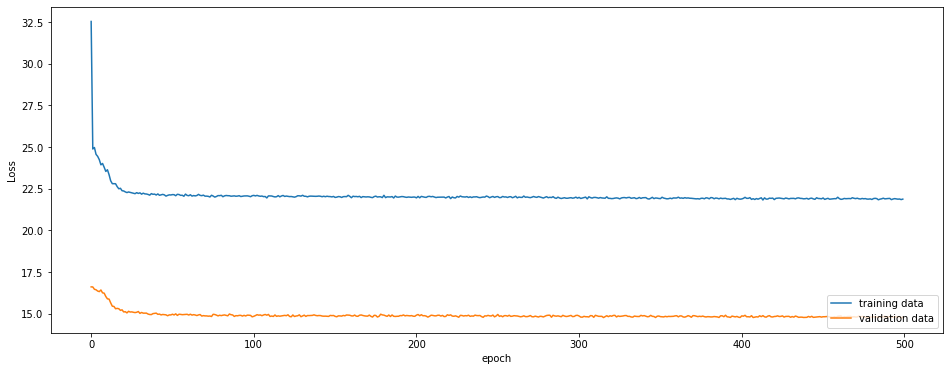

In [26]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model1.history['loss'])
plt.plot(learning_model1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [27]:
model1 = tf.keras.models.load_model('LSTM_timestepTest_oneTimestep.h5')

In [28]:
#performance on training set
trainPredict1 = model1.predict(trainX_1step_arr)
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY_1step_arr, trainPredict1))
trainR2Score1 = r2_score(trainY_1step_arr, trainPredict1)
trainSscore1 = findSscore(trainY_1step_arr, trainPredict1)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore1, trainR2Score1, trainSscore1))

Train Score: 4.6585 RMSE 0.0755 R2 Score 7826.2958 S score


In [29]:
#performance on validation set
valPredict1 = model1.predict(valX_1step_arr)
# calculate root mean squared error
valScore1 = math.sqrt(mean_squared_error(valY_1step_arr, valPredict1))
valR2Score1 = r2_score(valY_1step_arr, valPredict1)
valSscore1 = findSscore(valY_1step_arr, valPredict1)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore1, valR2Score1, valSscore1))

Validation Score: 3.8408 RMSE 0.0966 R2 Score 1200.6274 S score


In [30]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

In [31]:
valTime_1step

[6011,
 6012,
 6013,
 6014,
 6015,
 6016,
 6017,
 6018,
 6019,
 6020,
 6021,
 6022,
 6023,
 6025,
 6026,
 6027,
 6029,
 6030,
 6031,
 6032,
 6033,
 6034,
 6035,
 6036,
 6037,
 6038,
 6039,
 6040,
 6042,
 6043,
 6044,
 6045,
 6046,
 6047,
 6048,
 6049,
 6050,
 6052,
 6053,
 6054,
 6055,
 6056,
 6057,
 6058,
 6059,
 6060,
 6061,
 6062,
 6063,
 6064,
 6065,
 6066,
 6068,
 6069,
 6070,
 6071,
 6072,
 6073,
 6074,
 6076,
 6077,
 6078,
 6079,
 6080,
 6081,
 6082,
 6083,
 6084,
 6085,
 6086,
 6087,
 6088,
 6090,
 6091,
 6092,
 6093,
 6094,
 6095,
 6096,
 6097,
 6098,
 6099,
 6100,
 6101,
 6102,
 6104,
 6105,
 6106,
 6107,
 6108,
 6109,
 6110,
 6111,
 6112,
 6113,
 6114,
 6115,
 6116,
 6118,
 6119,
 6120,
 6121,
 6123,
 6124,
 6125,
 6126,
 6127,
 6129,
 6130,
 6131,
 6132,
 6133,
 6134,
 6135,
 6137,
 6138,
 6139,
 6140,
 6141,
 6142,
 6143,
 6145,
 6146,
 6147,
 6148,
 6149,
 6150,
 6151,
 6152,
 6153,
 6154,
 6156,
 6157,
 6158,
 6159,
 6160,
 6161,
 6162,
 6163,
 6164,
 6166,
 6167,
 6168,

In [32]:
allRUL = all_df['RUL']
(actualVal1, predictedVal1) = getRULValues(valPredict1, allRUL, valTime_1step, 6010, 6976)

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


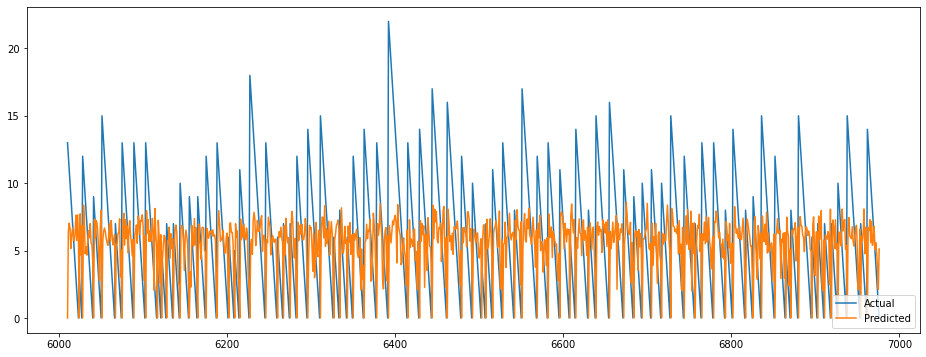

In [33]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal1)
plt.plot(timeLabels, predictedVal1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

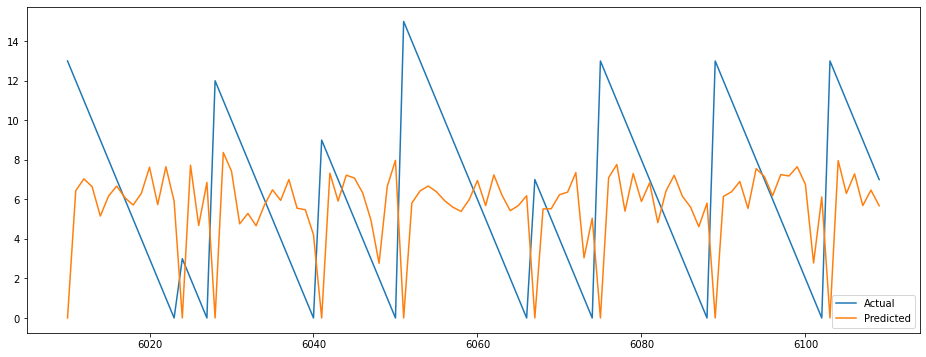

In [34]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal1[0:100])
plt.plot(timeLabels[0:100], predictedVal1[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 2: Timestep = 2

In [35]:
(trainX_2step, trainY_2step, trainTime_2step) = splitDataIntoChunks3D(train_data, 2)
(valX_2step, valY_2step, valTime_2step) = splitDataIntoChunks3D(val_data, 2)
(testX_2step, testY_2step, testTime_2step) = splitDataIntoChunks3D(test_data, 2)

In [36]:
#check shape of X (training)
trainX_2step_arr = np.array(trainX_2step)
trainX_2step_arr.shape

(5008, 2, 4)

In [37]:
#check shape of y (training)
trainY_2step_arr = np.array(trainY_2step)
trainY_2step_arr = trainY_2step_arr.reshape(-1, 1)
trainY_2step_arr.shape

(5008, 1)

In [38]:
#check shape of X (validation)
valX_2step_arr = np.array(valX_2step)
valX_2step_arr.shape

(801, 2, 4)

In [39]:
#check shape of y (validation)
valY_2step_arr = np.array(valY_2step)
valY_2step_arr = valY_2step_arr.reshape(-1, 1)
valY_2step_arr.shape

(801, 1)

In [44]:
#configure architecture 
model2 = models.Sequential()
model2.add(layers.LSTM(128, activation='tanh', 
                       input_shape=(2,4), return_sequences=True))
model2.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model2.add(layers.Dropout(0.5))
model2.add(layers.LSTM(32, activation='tanh'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))

In [45]:
model2.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [46]:
fileName2 = "LSTM_timestepTest_twoTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName2,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [47]:
learning_model2 = model2.fit(trainX_2step_arr, trainY_2step_arr, epochs=500, batch_size=32, validation_data=(valX_2step_arr, valY_2step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
157/157 [==============================] - 8s 19ms/step - loss: 24.8239 - mean_squared_error: 24.8239 - val_loss: 15.0835 - val_mean_squared_error: 15.0835
Epoch 2/500
157/157 [==============================] - 2s 10ms/step - loss: 22.9740 - mean_squared_error: 22.9740 - val_loss: 14.7387 - val_mean_squared_error: 14.7387
Epoch 3/500
157/157 [==============================] - 1s 9ms/step - loss: 22.5084 - mean_squared_error: 22.5084 - val_loss: 14.6727 - val_mean_squared_error: 14.6727
Epoch 4/500
157/157 [==============================] - 1s 9ms/step - loss: 22.2417 - mean_squared_error: 22.2417 - val_loss: 14.5776 - val_mean_squared_error: 14.5776
Epoch 5/500
157/157 [==============================] - 1s 9ms/step - loss: 22.3372 - mean_squared_error: 22.3372 - val_loss: 14.5462 - val_mean_squared_error: 14.5462
Epoch 6/500
157/157 [==============================] - 1s 9ms/step - loss: 21.9941 - mean_squared_error: 21.9941 - val_loss: 14.5441 - val_mean_squared_error: 14.5

Epoch 50/500
157/157 [==============================] - 1s 8ms/step - loss: 19.9244 - mean_squared_error: 19.9244 - val_loss: 12.5186 - val_mean_squared_error: 12.5186
Epoch 51/500
157/157 [==============================] - 1s 8ms/step - loss: 19.9074 - mean_squared_error: 19.9074 - val_loss: 12.4563 - val_mean_squared_error: 12.4563
Epoch 52/500
157/157 [==============================] - 1s 8ms/step - loss: 19.8460 - mean_squared_error: 19.8460 - val_loss: 12.4825 - val_mean_squared_error: 12.4825
Epoch 53/500
157/157 [==============================] - 1s 9ms/step - loss: 19.8864 - mean_squared_error: 19.8864 - val_loss: 12.4555 - val_mean_squared_error: 12.4555
Epoch 54/500
157/157 [==============================] - 1s 9ms/step - loss: 19.7896 - mean_squared_error: 19.7896 - val_loss: 12.4709 - val_mean_squared_error: 12.4709
Epoch 55/500
157/157 [==============================] - 1s 8ms/step - loss: 19.9382 - mean_squared_error: 19.9382 - val_loss: 12.5045 - val_mean_squared_error: 

Epoch 99/500
157/157 [==============================] - 1s 7ms/step - loss: 19.8492 - mean_squared_error: 19.8492 - val_loss: 12.5036 - val_mean_squared_error: 12.5036
Epoch 100/500
157/157 [==============================] - 1s 8ms/step - loss: 19.7436 - mean_squared_error: 19.7436 - val_loss: 12.4083 - val_mean_squared_error: 12.4083
Epoch 101/500
157/157 [==============================] - 1s 9ms/step - loss: 19.8549 - mean_squared_error: 19.8549 - val_loss: 12.4541 - val_mean_squared_error: 12.4541
Epoch 102/500
157/157 [==============================] - 1s 8ms/step - loss: 19.8162 - mean_squared_error: 19.8162 - val_loss: 12.5743 - val_mean_squared_error: 12.5743
Epoch 103/500
157/157 [==============================] - 1s 8ms/step - loss: 19.7834 - mean_squared_error: 19.7834 - val_loss: 12.4373 - val_mean_squared_error: 12.4373
Epoch 104/500
157/157 [==============================] - 1s 8ms/step - loss: 19.8479 - mean_squared_error: 19.8479 - val_loss: 12.4992 - val_mean_squared_er

157/157 [==============================] - 1s 9ms/step - loss: 19.6964 - mean_squared_error: 19.6964 - val_loss: 12.4132 - val_mean_squared_error: 12.4132
Epoch 196/500
157/157 [==============================] - 1s 9ms/step - loss: 19.7144 - mean_squared_error: 19.7144 - val_loss: 12.5529 - val_mean_squared_error: 12.5529
Epoch 197/500
157/157 [==============================] - 1s 9ms/step - loss: 19.7019 - mean_squared_error: 19.7019 - val_loss: 12.3824 - val_mean_squared_error: 12.3824
Epoch 198/500
157/157 [==============================] - 1s 8ms/step - loss: 19.7471 - mean_squared_error: 19.7471 - val_loss: 12.4732 - val_mean_squared_error: 12.4732
Epoch 199/500
157/157 [==============================] - 1s 9ms/step - loss: 19.6441 - mean_squared_error: 19.6441 - val_loss: 12.3987 - val_mean_squared_error: 12.3987
Epoch 200/500
157/157 [==============================] - 1s 9ms/step - loss: 19.6707 - mean_squared_error: 19.6707 - val_loss: 12.4990 - val_mean_squared_error: 12.4990


157/157 [==============================] - 1s 9ms/step - loss: 19.6313 - mean_squared_error: 19.6313 - val_loss: 12.4032 - val_mean_squared_error: 12.4032
Epoch 292/500
157/157 [==============================] - 1s 9ms/step - loss: 19.6005 - mean_squared_error: 19.6005 - val_loss: 12.3837 - val_mean_squared_error: 12.3837
Epoch 293/500
157/157 [==============================] - 1s 8ms/step - loss: 19.6370 - mean_squared_error: 19.6370 - val_loss: 12.4387 - val_mean_squared_error: 12.4387
Epoch 294/500
157/157 [==============================] - 1s 8ms/step - loss: 19.6765 - mean_squared_error: 19.6765 - val_loss: 12.4115 - val_mean_squared_error: 12.4115
Epoch 295/500
157/157 [==============================] - 1s 8ms/step - loss: 19.6515 - mean_squared_error: 19.6515 - val_loss: 12.4146 - val_mean_squared_error: 12.4146
Epoch 296/500
157/157 [==============================] - 1s 8ms/step - loss: 19.6352 - mean_squared_error: 19.6352 - val_loss: 12.4360 - val_mean_squared_error: 12.4360


157/157 [==============================] - 1s 8ms/step - loss: 19.5429 - mean_squared_error: 19.5429 - val_loss: 12.3676 - val_mean_squared_error: 12.3676
Epoch 388/500
157/157 [==============================] - 1s 8ms/step - loss: 19.5533 - mean_squared_error: 19.5533 - val_loss: 12.4859 - val_mean_squared_error: 12.4859
Epoch 389/500
157/157 [==============================] - 1s 8ms/step - loss: 19.5307 - mean_squared_error: 19.5307 - val_loss: 12.5267 - val_mean_squared_error: 12.5267
Epoch 390/500
157/157 [==============================] - 1s 9ms/step - loss: 19.4771 - mean_squared_error: 19.4771 - val_loss: 12.3746 - val_mean_squared_error: 12.3746
Epoch 391/500
157/157 [==============================] - 1s 9ms/step - loss: 19.5407 - mean_squared_error: 19.5407 - val_loss: 12.4656 - val_mean_squared_error: 12.4656
Epoch 392/500
157/157 [==============================] - 1s 9ms/step - loss: 19.4588 - mean_squared_error: 19.4588 - val_loss: 12.4698 - val_mean_squared_error: 12.4698


157/157 [==============================] - 1s 9ms/step - loss: 19.3773 - mean_squared_error: 19.3773 - val_loss: 12.5257 - val_mean_squared_error: 12.5257
Epoch 484/500
157/157 [==============================] - 1s 8ms/step - loss: 19.4133 - mean_squared_error: 19.4133 - val_loss: 12.5273 - val_mean_squared_error: 12.5273
Epoch 485/500
157/157 [==============================] - 1s 8ms/step - loss: 19.3433 - mean_squared_error: 19.3433 - val_loss: 12.3202 - val_mean_squared_error: 12.3202
Epoch 486/500
157/157 [==============================] - 1s 9ms/step - loss: 19.2837 - mean_squared_error: 19.2837 - val_loss: 12.4552 - val_mean_squared_error: 12.4552
Epoch 487/500
157/157 [==============================] - 1s 8ms/step - loss: 19.3914 - mean_squared_error: 19.3914 - val_loss: 12.5704 - val_mean_squared_error: 12.5704
Epoch 488/500
157/157 [==============================] - 1s 9ms/step - loss: 19.3164 - mean_squared_error: 19.3164 - val_loss: 12.3065 - val_mean_squared_error: 12.3065


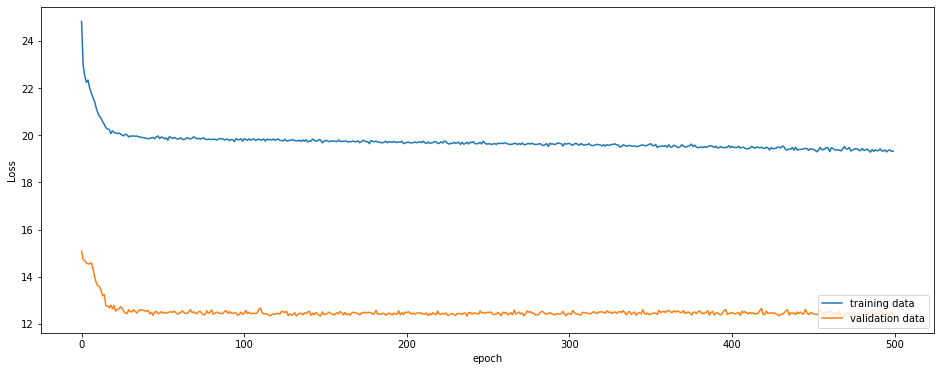

In [105]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model2.history['loss'])
plt.plot(learning_model2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [48]:
model2 = tf.keras.models.load_model('LSTM_timestepTest_twoTimestep.h5')

In [49]:
#performance on training set
trainPredict2 = model2.predict(trainX_2step_arr)
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY_2step_arr, trainPredict2))
trainR2Score2 = r2_score(trainY_2step_arr, trainPredict2)
trainSscore2 = findSscore(trainY_2step_arr, trainPredict2)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore2, trainR2Score2, trainSscore2))

Train Score: 4.3884 RMSE 0.1134 R2 Score 6931.1551 S score


In [50]:
#performance on validation set
valPredict2 = model2.predict(valX_2step_arr)
# calculate root mean squared error
valScore2 = math.sqrt(mean_squared_error(valY_2step_arr, valPredict2))
valR2Score2 = r2_score(valY_2step_arr, valPredict2)
valSscore2 = findSscore(valY_2step_arr, valPredict2)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore2, valR2Score2, valSscore2))

Validation Score: 3.5001 RMSE 0.1593 R2 Score 1056.0848 S score


In [51]:
(actualVal2, predictedVal2) = getRULValues(valPredict2, allRUL, valTime_2step, 6010, 6976)

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


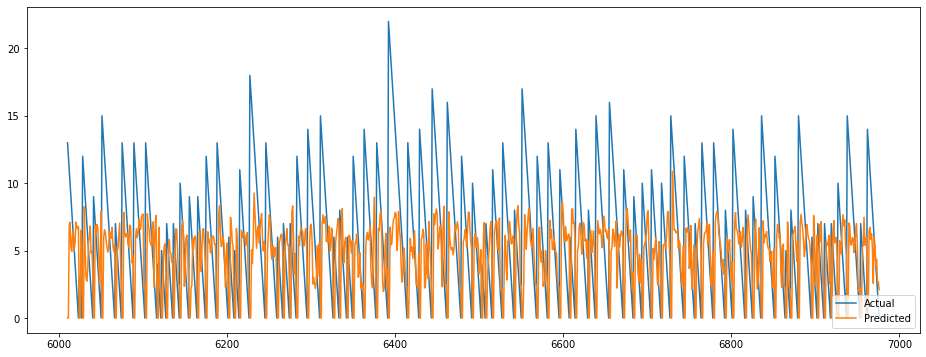

In [52]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal2)
plt.plot(timeLabels, predictedVal2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

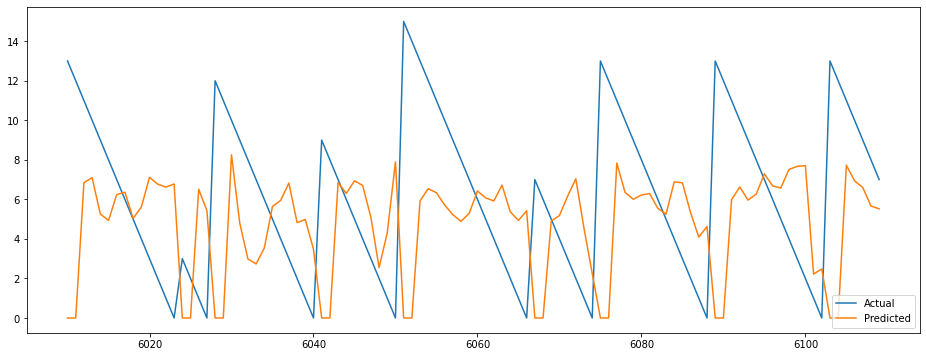

In [53]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal2[0:100])
plt.plot(timeLabels[0:100], predictedVal2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 3: Timesteps = 3

In [54]:
(trainX_3step, trainY_3step, trainTime_3step) = splitDataIntoChunks3D(train_data, 3)
(valX_3step, valY_3step, valTime_3step) = splitDataIntoChunks3D(val_data, 3)
(testX_3step, testY_3step, testTime_3step) = splitDataIntoChunks3D(test_data, 3)

In [55]:
#check shape of X (training)
trainX_3step_arr = np.array(trainX_3step)
trainX_3step_arr.shape

(4511, 3, 4)

In [56]:
#check shape of y (training)
trainY_3step_arr = np.array(trainY_3step)
trainY_3step_arr = trainY_3step_arr.reshape(-1, 1)
trainY_3step_arr.shape

(4511, 1)

In [57]:
#check shape of X (validation)
valX_3step_arr = np.array(valX_3step)
valX_3step_arr.shape

(718, 3, 4)

In [58]:
#check shape of y (validation)
valY_3step_arr = np.array(valY_3step)
valY_3step_arr = valY_3step_arr.reshape(-1, 1)
valY_3step_arr.shape

(718, 1)

In [59]:
#configure architecture 
model3 = models.Sequential()
model3.add(layers.LSTM(128, activation='tanh', 
                       input_shape=(3,4), return_sequences=True))
model3.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model3.add(layers.Dropout(0.5))
model3.add(layers.LSTM(32, activation='tanh'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(1, activation='relu'))

In [60]:
model3.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [61]:
fileName3 = "LSTM_timestepTest_threeTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName3,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [62]:
learning_model3 = model3.fit(trainX_3step_arr, trainY_3step_arr, epochs=500, batch_size=32, validation_data=(valX_3step_arr, valY_3step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
141/141 [==============================] - 8s 21ms/step - loss: 22.6238 - mean_squared_error: 22.6238 - val_loss: 13.0563 - val_mean_squared_error: 13.0563
Epoch 2/500
141/141 [==============================] - 1s 10ms/step - loss: 21.2688 - mean_squared_error: 21.2688 - val_loss: 12.9511 - val_mean_squared_error: 12.9511
Epoch 3/500
141/141 [==============================] - 1s 9ms/step - loss: 20.8144 - mean_squared_error: 20.8144 - val_loss: 12.9595 - val_mean_squared_error: 12.9595
Epoch 4/500
141/141 [==============================] - 1s 9ms/step - loss: 20.7196 - mean_squared_error: 20.7196 - val_loss: 12.9711 - val_mean_squared_error: 12.9711
Epoch 5/500
141/141 [==============================] - 1s 9ms/step - loss: 20.6642 - mean_squared_error: 20.6642 - val_loss: 12.9886 - val_mean_squared_error: 12.9886
Epoch 6/500
141/141 [==============================] - 1s 9ms/step - loss: 20.7025 - mean_squared_error: 20.7025 - val_loss: 13.0672 - val_mean_squared_error: 13.0

Epoch 50/500
141/141 [==============================] - 1s 8ms/step - loss: 18.2930 - mean_squared_error: 18.2930 - val_loss: 10.7364 - val_mean_squared_error: 10.7364
Epoch 51/500
141/141 [==============================] - 1s 9ms/step - loss: 18.2257 - mean_squared_error: 18.2257 - val_loss: 10.8150 - val_mean_squared_error: 10.8150
Epoch 52/500
141/141 [==============================] - 1s 9ms/step - loss: 18.3014 - mean_squared_error: 18.3014 - val_loss: 10.9142 - val_mean_squared_error: 10.9142
Epoch 53/500
141/141 [==============================] - 1s 9ms/step - loss: 18.3221 - mean_squared_error: 18.3221 - val_loss: 10.8640 - val_mean_squared_error: 10.8640
Epoch 54/500
141/141 [==============================] - 1s 9ms/step - loss: 18.2246 - mean_squared_error: 18.2246 - val_loss: 10.8006 - val_mean_squared_error: 10.8006
Epoch 55/500
141/141 [==============================] - 1s 9ms/step - loss: 18.2576 - mean_squared_error: 18.2576 - val_loss: 10.8331 - val_mean_squared_error: 

Epoch 99/500
141/141 [==============================] - 1s 9ms/step - loss: 18.1891 - mean_squared_error: 18.1891 - val_loss: 10.6949 - val_mean_squared_error: 10.6949
Epoch 100/500
141/141 [==============================] - 1s 8ms/step - loss: 18.2863 - mean_squared_error: 18.2863 - val_loss: 10.7812 - val_mean_squared_error: 10.7812
Epoch 101/500
141/141 [==============================] - 1s 8ms/step - loss: 18.1544 - mean_squared_error: 18.1544 - val_loss: 10.6958 - val_mean_squared_error: 10.6958
Epoch 102/500
141/141 [==============================] - 1s 8ms/step - loss: 18.2225 - mean_squared_error: 18.2225 - val_loss: 10.6875 - val_mean_squared_error: 10.6875
Epoch 103/500
141/141 [==============================] - 1s 10ms/step - loss: 18.2289 - mean_squared_error: 18.2289 - val_loss: 10.6174 - val_mean_squared_error: 10.6174
Epoch 104/500
141/141 [==============================] - 1s 8ms/step - loss: 18.1282 - mean_squared_error: 18.1282 - val_loss: 10.8379 - val_mean_squared_e

141/141 [==============================] - 1s 8ms/step - loss: 18.0814 - mean_squared_error: 18.0814 - val_loss: 10.7308 - val_mean_squared_error: 10.7308
Epoch 196/500
141/141 [==============================] - 1s 9ms/step - loss: 18.0525 - mean_squared_error: 18.0525 - val_loss: 10.8308 - val_mean_squared_error: 10.8308
Epoch 197/500
141/141 [==============================] - 1s 8ms/step - loss: 18.1487 - mean_squared_error: 18.1487 - val_loss: 10.7792 - val_mean_squared_error: 10.7792
Epoch 198/500
141/141 [==============================] - 1s 10ms/step - loss: 18.0119 - mean_squared_error: 18.0119 - val_loss: 10.8276 - val_mean_squared_error: 10.8276
Epoch 199/500
141/141 [==============================] - 1s 9ms/step - loss: 18.0422 - mean_squared_error: 18.0422 - val_loss: 10.7712 - val_mean_squared_error: 10.7712
Epoch 200/500
141/141 [==============================] - 1s 9ms/step - loss: 18.0469 - mean_squared_error: 18.0469 - val_loss: 10.9529 - val_mean_squared_error: 10.9529

141/141 [==============================] - 1s 9ms/step - loss: 17.8111 - mean_squared_error: 17.8111 - val_loss: 10.9450 - val_mean_squared_error: 10.9450
Epoch 292/500
141/141 [==============================] - 1s 9ms/step - loss: 17.7635 - mean_squared_error: 17.7635 - val_loss: 11.0768 - val_mean_squared_error: 11.0768
Epoch 293/500
141/141 [==============================] - 1s 8ms/step - loss: 17.7659 - mean_squared_error: 17.7659 - val_loss: 10.9492 - val_mean_squared_error: 10.9492
Epoch 294/500
141/141 [==============================] - 1s 9ms/step - loss: 17.8312 - mean_squared_error: 17.8312 - val_loss: 10.9828 - val_mean_squared_error: 10.9828
Epoch 295/500
141/141 [==============================] - 1s 9ms/step - loss: 17.7185 - mean_squared_error: 17.7185 - val_loss: 10.8955 - val_mean_squared_error: 10.8955
Epoch 296/500
141/141 [==============================] - 1s 9ms/step - loss: 17.7164 - mean_squared_error: 17.7164 - val_loss: 10.7920 - val_mean_squared_error: 10.7920


141/141 [==============================] - 1s 9ms/step - loss: 17.3022 - mean_squared_error: 17.3022 - val_loss: 11.0731 - val_mean_squared_error: 11.0731
Epoch 388/500
141/141 [==============================] - 1s 9ms/step - loss: 17.2735 - mean_squared_error: 17.2735 - val_loss: 11.3750 - val_mean_squared_error: 11.3750
Epoch 389/500
141/141 [==============================] - 1s 9ms/step - loss: 17.4487 - mean_squared_error: 17.4487 - val_loss: 11.3642 - val_mean_squared_error: 11.3642
Epoch 390/500
141/141 [==============================] - 1s 9ms/step - loss: 17.3825 - mean_squared_error: 17.3825 - val_loss: 11.3649 - val_mean_squared_error: 11.3649
Epoch 391/500
141/141 [==============================] - 1s 8ms/step - loss: 17.4012 - mean_squared_error: 17.4012 - val_loss: 11.3607 - val_mean_squared_error: 11.3607
Epoch 392/500
141/141 [==============================] - 1s 9ms/step - loss: 17.3729 - mean_squared_error: 17.3729 - val_loss: 11.1273 - val_mean_squared_error: 11.1273


141/141 [==============================] - 1s 9ms/step - loss: 17.3790 - mean_squared_error: 17.3790 - val_loss: 11.6509 - val_mean_squared_error: 11.6509
Epoch 484/500
141/141 [==============================] - 1s 8ms/step - loss: 17.2875 - mean_squared_error: 17.2875 - val_loss: 11.2743 - val_mean_squared_error: 11.2743
Epoch 485/500
141/141 [==============================] - 1s 9ms/step - loss: 17.2026 - mean_squared_error: 17.2026 - val_loss: 11.3054 - val_mean_squared_error: 11.3054
Epoch 486/500
141/141 [==============================] - 1s 9ms/step - loss: 17.2195 - mean_squared_error: 17.2195 - val_loss: 11.3067 - val_mean_squared_error: 11.3067
Epoch 487/500
141/141 [==============================] - 1s 9ms/step - loss: 16.9408 - mean_squared_error: 16.9408 - val_loss: 11.4556 - val_mean_squared_error: 11.4556
Epoch 488/500
141/141 [==============================] - 1s 9ms/step - loss: 16.8909 - mean_squared_error: 16.8909 - val_loss: 11.3977 - val_mean_squared_error: 11.3977


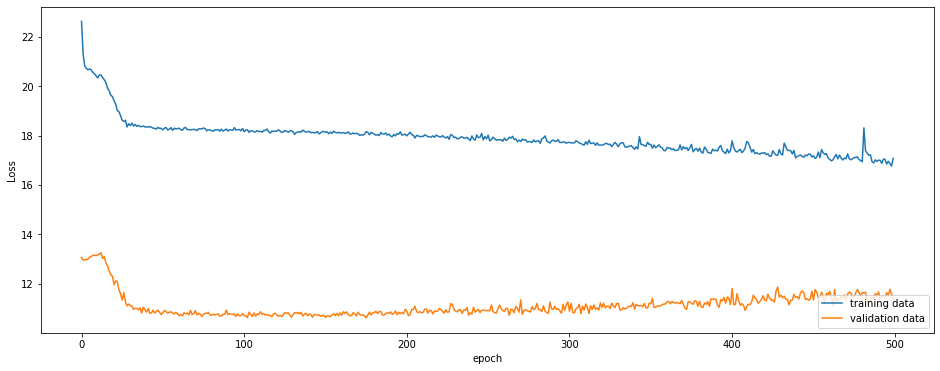

In [106]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model3.history['loss'])
plt.plot(learning_model3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [63]:
model3 = tf.keras.models.load_model('LSTM_timestepTest_threeTimestep.h5')

In [64]:
#performance on training set
trainPredict3 = model3.predict(trainX_3step_arr)
# calculate root mean squared error
trainScore3 = math.sqrt(mean_squared_error(trainY_3step_arr, trainPredict3))
trainR2Score3 = r2_score(trainY_3step_arr, trainPredict3)
trainSscore3 = findSscore(trainY_3step_arr, trainPredict3)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore3, trainR2Score3, trainSscore3))

Train Score: 4.2113 RMSE 0.1185 R2 Score 6149.7884 S score


In [65]:
#performance on validation set
valPredict3 = model3.predict(valX_3step_arr)
# calculate root mean squared error
valScore3 = math.sqrt(mean_squared_error(valY_3step_arr, valPredict3))
valR2Score3 = r2_score(valY_3step_arr, valPredict3)
valSscore3 = findSscore(valY_3step_arr, valPredict3)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore3, valR2Score3, valSscore3))

Validation Score: 3.2561 RMSE 0.1815 R2 Score 929.7745 S score


In [66]:
allRUL = all_df['RUL']
(actualVal3, predictedVal3) = getRULValues(valPredict3, allRUL, valTime_3step, 6010, 6976)

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


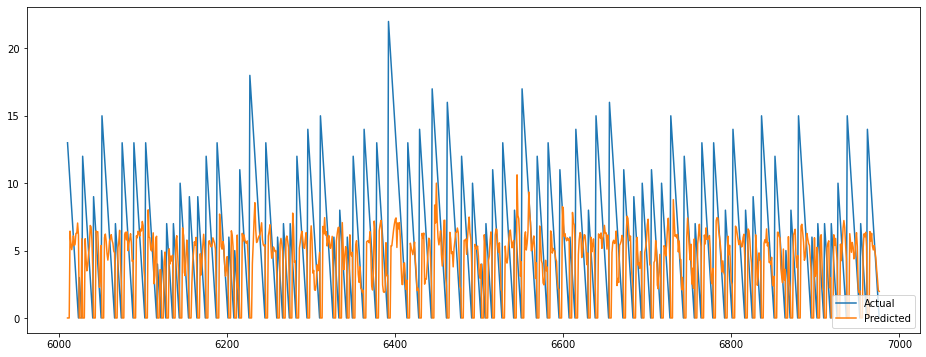

In [67]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal3)
plt.plot(timeLabels, predictedVal3)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

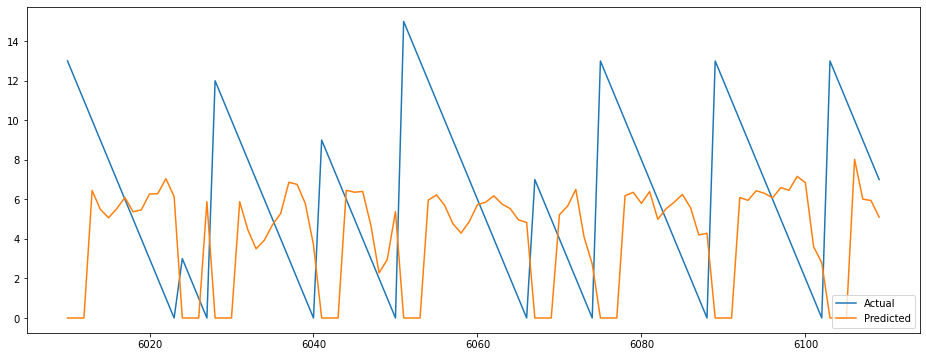

In [68]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal3[0:100])
plt.plot(timeLabels[0:100], predictedVal3[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 4: Timesteps = 4

In [69]:
(trainX_4step, trainY_4step, trainTime_4step) = splitDataIntoChunks3D(train_data, 4)
(valX_4step, valY_4step, valTime_4step) = splitDataIntoChunks3D(val_data, 4)
(testX_4step, testY_4step, testTime_4step) = splitDataIntoChunks3D(test_data, 4)

In [70]:
#check shape of X (training)
trainX_4step_arr = np.array(trainX_4step)
trainX_4step_arr.shape

(4022, 4, 4)

In [71]:
#check shape of y (training)
trainY_4step_arr = np.array(trainY_4step)
trainY_4step_arr = trainY_4step_arr.reshape(-1, 1)
trainY_4step_arr.shape

(4022, 1)

In [72]:
#check shape of X (validation)
valX_4step_arr = np.array(valX_4step)
valX_4step_arr.shape

(635, 4, 4)

In [73]:
#check shape of y (validation)
valY_4step_arr = np.array(valY_4step)
valY_4step_arr = valY_4step_arr.reshape(-1, 1)
valY_4step_arr.shape

(635, 1)

In [78]:
#configure architecture 
model4 = models.Sequential()
model4.add(layers.LSTM(128, activation='tanh', 
                       input_shape=(4,4), return_sequences=True))
model4.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model4.add(layers.Dropout(0.5))
model4.add(layers.LSTM(32, activation='tanh'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(100, activation='relu'))
model4.add(layers.Dense(1, activation='relu'))

In [79]:
model4.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [80]:
fileName4 = "LSTM_timestepTest_fourTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName4,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [81]:
learning_model4 = model4.fit(trainX_4step_arr, trainY_4step_arr, epochs=500, batch_size=32, validation_data=(valX_4step_arr, valY_4step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 7s 21ms/step - loss: 21.3861 - mean_squared_error: 21.3861 - val_loss: 11.4556 - val_mean_squared_error: 11.4556
Epoch 2/500
126/126 [==============================] - 1s 8ms/step - loss: 19.4636 - mean_squared_error: 19.4636 - val_loss: 11.4719 - val_mean_squared_error: 11.4719
Epoch 3/500
126/126 [==============================] - 1s 9ms/step - loss: 19.2773 - mean_squared_error: 19.2773 - val_loss: 11.5227 - val_mean_squared_error: 11.5227
Epoch 4/500
126/126 [==============================] - 1s 9ms/step - loss: 19.1612 - mean_squared_error: 19.1612 - val_loss: 11.5633 - val_mean_squared_error: 11.5633
Epoch 5/500
126/126 [==============================] - 1s 8ms/step - loss: 19.1060 - mean_squared_error: 19.1060 - val_loss: 11.6873 - val_mean_squared_error: 11.6873
Epoch 6/500
126/126 [==============================] - 1s 9ms/step - loss: 19.1380 - mean_squared_error: 19.1380 - val_loss: 11.7164 - val_mean_squared_error: 11.71

Epoch 50/500
126/126 [==============================] - 1s 10ms/step - loss: 17.4792 - mean_squared_error: 17.4792 - val_loss: 10.2940 - val_mean_squared_error: 10.2940
Epoch 51/500
126/126 [==============================] - 1s 10ms/step - loss: 17.3713 - mean_squared_error: 17.3713 - val_loss: 10.0257 - val_mean_squared_error: 10.0257
Epoch 52/500
126/126 [==============================] - 1s 9ms/step - loss: 17.3396 - mean_squared_error: 17.3396 - val_loss: 10.0751 - val_mean_squared_error: 10.0751
Epoch 53/500
126/126 [==============================] - 1s 9ms/step - loss: 17.1386 - mean_squared_error: 17.1386 - val_loss: 9.7335 - val_mean_squared_error: 9.7335
Epoch 54/500
126/126 [==============================] - 1s 10ms/step - loss: 17.0739 - mean_squared_error: 17.0739 - val_loss: 9.6775 - val_mean_squared_error: 9.6775
Epoch 55/500
126/126 [==============================] - 1s 8ms/step - loss: 17.1131 - mean_squared_error: 17.1131 - val_loss: 9.8289 - val_mean_squared_error: 9.

126/126 [==============================] - 1s 10ms/step - loss: 16.4525 - mean_squared_error: 16.4525 - val_loss: 9.3206 - val_mean_squared_error: 9.3206
Epoch 149/500
126/126 [==============================] - 1s 8ms/step - loss: 16.4363 - mean_squared_error: 16.4363 - val_loss: 9.2648 - val_mean_squared_error: 9.2648
Epoch 150/500
126/126 [==============================] - 1s 9ms/step - loss: 16.5097 - mean_squared_error: 16.5097 - val_loss: 9.0774 - val_mean_squared_error: 9.0774
Epoch 151/500
126/126 [==============================] - 1s 10ms/step - loss: 16.5346 - mean_squared_error: 16.5346 - val_loss: 9.0012 - val_mean_squared_error: 9.0012
Epoch 152/500
126/126 [==============================] - 1s 9ms/step - loss: 16.5197 - mean_squared_error: 16.5197 - val_loss: 9.0754 - val_mean_squared_error: 9.0754
Epoch 153/500
126/126 [==============================] - 1s 8ms/step - loss: 16.4469 - mean_squared_error: 16.4469 - val_loss: 9.1157 - val_mean_squared_error: 9.1157
Epoch 154/

126/126 [==============================] - 1s 9ms/step - loss: 15.8869 - mean_squared_error: 15.8869 - val_loss: 9.2560 - val_mean_squared_error: 9.2560
Epoch 247/500
126/126 [==============================] - 1s 8ms/step - loss: 16.0570 - mean_squared_error: 16.0570 - val_loss: 9.1746 - val_mean_squared_error: 9.1746
Epoch 248/500
126/126 [==============================] - 1s 8ms/step - loss: 15.9370 - mean_squared_error: 15.9370 - val_loss: 9.1865 - val_mean_squared_error: 9.1865
Epoch 249/500
126/126 [==============================] - 1s 10ms/step - loss: 15.8973 - mean_squared_error: 15.8973 - val_loss: 9.3413 - val_mean_squared_error: 9.3413
Epoch 250/500
126/126 [==============================] - 1s 9ms/step - loss: 15.7279 - mean_squared_error: 15.7279 - val_loss: 9.2940 - val_mean_squared_error: 9.2940
Epoch 251/500
126/126 [==============================] - 1s 8ms/step - loss: 15.8356 - mean_squared_error: 15.8356 - val_loss: 9.4051 - val_mean_squared_error: 9.4051
Epoch 252/5

126/126 [==============================] - 1s 10ms/step - loss: 15.3101 - mean_squared_error: 15.3101 - val_loss: 9.5323 - val_mean_squared_error: 9.5323
Epoch 345/500
126/126 [==============================] - 1s 9ms/step - loss: 15.1931 - mean_squared_error: 15.1931 - val_loss: 9.5644 - val_mean_squared_error: 9.5644
Epoch 346/500
126/126 [==============================] - 1s 8ms/step - loss: 15.3691 - mean_squared_error: 15.3691 - val_loss: 9.4387 - val_mean_squared_error: 9.4387
Epoch 347/500
126/126 [==============================] - 1s 8ms/step - loss: 15.4694 - mean_squared_error: 15.4694 - val_loss: 9.5560 - val_mean_squared_error: 9.5560
Epoch 348/500
126/126 [==============================] - 1s 9ms/step - loss: 15.2502 - mean_squared_error: 15.2502 - val_loss: 9.6739 - val_mean_squared_error: 9.6739
Epoch 349/500
126/126 [==============================] - 1s 9ms/step - loss: 15.2393 - mean_squared_error: 15.2393 - val_loss: 9.6774 - val_mean_squared_error: 9.6774
Epoch 350/5

Epoch 393/500
126/126 [==============================] - 1s 8ms/step - loss: 14.8844 - mean_squared_error: 14.8844 - val_loss: 10.0487 - val_mean_squared_error: 10.0487
Epoch 394/500
126/126 [==============================] - 1s 10ms/step - loss: 14.7405 - mean_squared_error: 14.7405 - val_loss: 10.0538 - val_mean_squared_error: 10.0538
Epoch 395/500
126/126 [==============================] - 1s 8ms/step - loss: 15.2855 - mean_squared_error: 15.2855 - val_loss: 10.0878 - val_mean_squared_error: 10.0878
Epoch 396/500
126/126 [==============================] - 1s 9ms/step - loss: 14.8136 - mean_squared_error: 14.8136 - val_loss: 9.7930 - val_mean_squared_error: 9.7930
Epoch 397/500
126/126 [==============================] - 1s 8ms/step - loss: 14.7359 - mean_squared_error: 14.7359 - val_loss: 10.1229 - val_mean_squared_error: 10.1229
Epoch 398/500
126/126 [==============================] - 1s 9ms/step - loss: 14.7402 - mean_squared_error: 14.7402 - val_loss: 9.8372 - val_mean_squared_err

126/126 [==============================] - 1s 8ms/step - loss: 13.7991 - mean_squared_error: 13.7991 - val_loss: 10.9320 - val_mean_squared_error: 10.9320
Epoch 490/500
126/126 [==============================] - 1s 9ms/step - loss: 13.6359 - mean_squared_error: 13.6359 - val_loss: 10.7476 - val_mean_squared_error: 10.7476
Epoch 491/500
126/126 [==============================] - 1s 9ms/step - loss: 13.8057 - mean_squared_error: 13.8057 - val_loss: 10.6542 - val_mean_squared_error: 10.6542
Epoch 492/500
126/126 [==============================] - 1s 8ms/step - loss: 13.9193 - mean_squared_error: 13.9193 - val_loss: 10.7061 - val_mean_squared_error: 10.7061
Epoch 493/500
126/126 [==============================] - 1s 9ms/step - loss: 13.6678 - mean_squared_error: 13.6678 - val_loss: 10.4585 - val_mean_squared_error: 10.4585
Epoch 494/500
126/126 [==============================] - 1s 8ms/step - loss: 13.7582 - mean_squared_error: 13.7582 - val_loss: 10.8904 - val_mean_squared_error: 10.8904


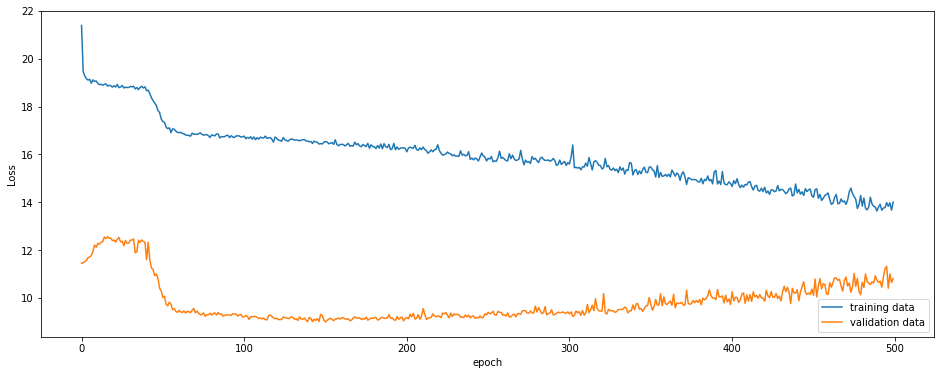

In [107]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model4.history['loss'])
plt.plot(learning_model4.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [82]:
model4 = tf.keras.models.load_model('LSTM_timestepTest_fourTimestep.h5')

In [83]:
#performance on training set
trainPredict4 = model4.predict(trainX_4step_arr)
# calculate root mean squared error
trainScore4 = math.sqrt(mean_squared_error(trainY_4step_arr, trainPredict4))
trainR2Score4 = r2_score(trainY_4step_arr, trainPredict4)
trainSscore4 = findSscore(trainY_4step_arr, trainPredict4)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore4, trainR2Score4, trainSscore4))

Train Score: 4.0314 RMSE 0.1295 R2 Score 5358.9696 S score


In [84]:
#performance on validation set
valPredict4 = model4.predict(valX_4step_arr)
# calculate root mean squared error
valScore4 = math.sqrt(mean_squared_error(valY_4step_arr, valPredict4))
valR2Score4 = r2_score(valY_4step_arr, valPredict4)
valSscore4 = findSscore(valY_4step_arr, valPredict4)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore4, valR2Score4, valSscore4))

Validation Score: 3.0002 RMSE 0.2142 R2 Score 801.9530 S score


In [85]:
(actualVal4, predictedVal4) = getRULValues(valPredict4, allRUL, valTime_4step, 6010, 6976)

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


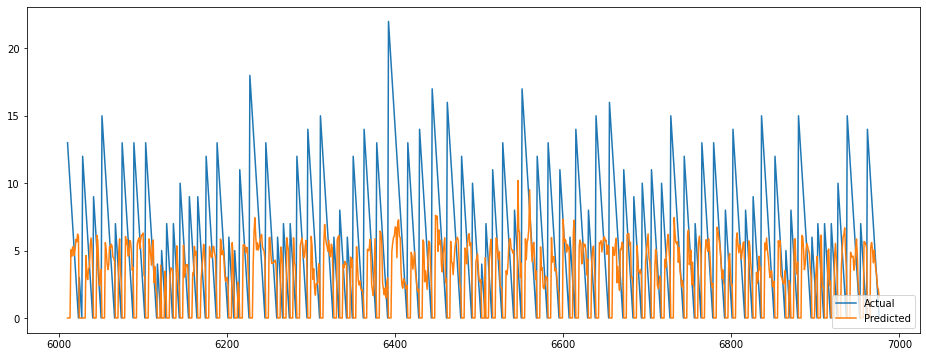

In [86]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal4)
plt.plot(timeLabels, predictedVal4)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

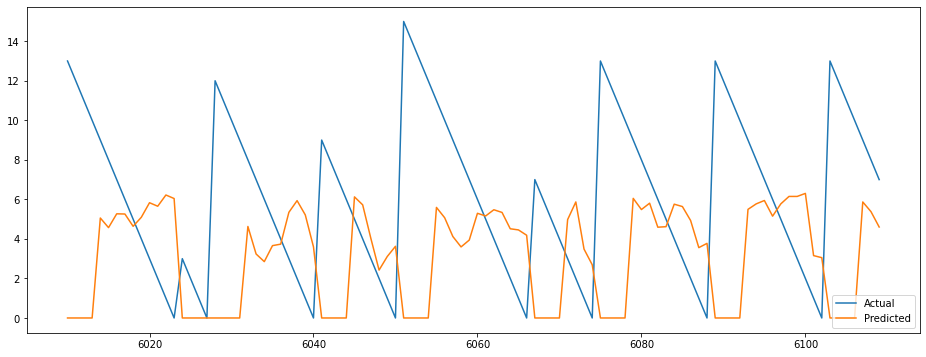

In [87]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal4[0:100])
plt.plot(timeLabels[0:100], predictedVal4[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 5: Timesteps = 5

In [88]:
(trainX_5step, trainY_5step, trainTime_5step) = splitDataIntoChunks3D(train_data, 5)
(valX_5step, valY_5step, valTime_5step) = splitDataIntoChunks3D(val_data, 5)
(testX_5step, testY_5step, testTime_5step) = splitDataIntoChunks3D(test_data, 5)

In [89]:
#check shape of X (training)
trainX_5step_arr = np.array(trainX_5step)
trainX_5step_arr.shape

(3542, 5, 4)

In [90]:
#check shape of y (training)
trainY_5step_arr = np.array(trainY_5step)
trainY_5step_arr = trainY_5step_arr.reshape(-1, 1)
trainY_5step_arr.shape

(3542, 1)

In [91]:
#check shape of X (validation)
valX_5step_arr = np.array(valX_5step)
valX_5step_arr.shape

(553, 5, 4)

In [92]:
#check shape of y (validation)
valY_5step_arr = np.array(valY_5step)
valY_5step_arr = valY_5step_arr.reshape(-1, 1)
valY_5step_arr.shape

(553, 1)

In [93]:
#configure architecture 
model5 = models.Sequential()
model5.add(layers.LSTM(128, activation='tanh', 
                       input_shape=(5,4), return_sequences=True))
model5.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model5.add(layers.Dropout(0.5))
model5.add(layers.LSTM(32, activation='tanh'))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(100, activation='relu'))
model5.add(layers.Dense(1, activation='relu'))

In [94]:
model5.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [95]:
fileName5 = "LSTM_timestepTest_fiveTimestep.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName5,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [96]:
learning_model5 = model5.fit(trainX_5step_arr, trainY_5step_arr, epochs=500, batch_size=32, validation_data=(valX_5step_arr, valY_5step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
111/111 [==============================] - 7s 24ms/step - loss: 19.2099 - mean_squared_error: 19.2099 - val_loss: 10.0805 - val_mean_squared_error: 10.0805
Epoch 2/500
111/111 [==============================] - 1s 9ms/step - loss: 18.2491 - mean_squared_error: 18.2491 - val_loss: 10.0873 - val_mean_squared_error: 10.0873
Epoch 3/500
111/111 [==============================] - 1s 10ms/step - loss: 18.0295 - mean_squared_error: 18.0295 - val_loss: 10.1619 - val_mean_squared_error: 10.1619
Epoch 4/500
111/111 [==============================] - 1s 9ms/step - loss: 17.8849 - mean_squared_error: 17.8849 - val_loss: 10.2328 - val_mean_squared_error: 10.2328
Epoch 5/500
111/111 [==============================] - 1s 9ms/step - loss: 17.7297 - mean_squared_error: 17.7297 - val_loss: 10.2553 - val_mean_squared_error: 10.2553
Epoch 6/500
111/111 [==============================] - 1s 9ms/step - loss: 17.7513 - mean_squared_error: 17.7513 - val_loss: 10.3585 - val_mean_squared_error: 10.3

Epoch 50/500
111/111 [==============================] - 1s 9ms/step - loss: 17.5419 - mean_squared_error: 17.5419 - val_loss: 11.3367 - val_mean_squared_error: 11.3367
Epoch 51/500
111/111 [==============================] - 1s 9ms/step - loss: 17.4947 - mean_squared_error: 17.4947 - val_loss: 11.3499 - val_mean_squared_error: 11.3499
Epoch 52/500
111/111 [==============================] - 1s 9ms/step - loss: 17.4935 - mean_squared_error: 17.4935 - val_loss: 11.3400 - val_mean_squared_error: 11.3400
Epoch 53/500
111/111 [==============================] - 1s 10ms/step - loss: 17.4871 - mean_squared_error: 17.4871 - val_loss: 11.2103 - val_mean_squared_error: 11.2103
Epoch 54/500
111/111 [==============================] - 1s 9ms/step - loss: 17.4827 - mean_squared_error: 17.4827 - val_loss: 11.2537 - val_mean_squared_error: 11.2537
Epoch 55/500
111/111 [==============================] - 1s 9ms/step - loss: 17.5126 - mean_squared_error: 17.5126 - val_loss: 11.1792 - val_mean_squared_error:

Epoch 99/500
111/111 [==============================] - 1s 9ms/step - loss: 17.4488 - mean_squared_error: 17.4488 - val_loss: 10.9212 - val_mean_squared_error: 10.9212
Epoch 100/500
111/111 [==============================] - 1s 9ms/step - loss: 17.5098 - mean_squared_error: 17.5098 - val_loss: 10.6497 - val_mean_squared_error: 10.6497
Epoch 101/500
111/111 [==============================] - 1s 9ms/step - loss: 17.4491 - mean_squared_error: 17.4491 - val_loss: 10.7658 - val_mean_squared_error: 10.7658
Epoch 102/500
111/111 [==============================] - 1s 10ms/step - loss: 17.4588 - mean_squared_error: 17.4588 - val_loss: 10.9618 - val_mean_squared_error: 10.9618
Epoch 103/500
111/111 [==============================] - 1s 9ms/step - loss: 17.4323 - mean_squared_error: 17.4323 - val_loss: 10.9429 - val_mean_squared_error: 10.9429
Epoch 104/500
111/111 [==============================] - 1s 9ms/step - loss: 17.4725 - mean_squared_error: 17.4725 - val_loss: 10.9125 - val_mean_squared_e

Epoch 196/500
111/111 [==============================] - 1s 9ms/step - loss: 15.5707 - mean_squared_error: 15.5707 - val_loss: 8.3969 - val_mean_squared_error: 8.3969
Epoch 197/500
111/111 [==============================] - 1s 10ms/step - loss: 15.5275 - mean_squared_error: 15.5275 - val_loss: 8.3962 - val_mean_squared_error: 8.3962
Epoch 198/500
111/111 [==============================] - 1s 11ms/step - loss: 15.5172 - mean_squared_error: 15.5172 - val_loss: 8.2896 - val_mean_squared_error: 8.2896
Epoch 199/500
111/111 [==============================] - 1s 11ms/step - loss: 15.5640 - mean_squared_error: 15.5640 - val_loss: 8.2517 - val_mean_squared_error: 8.2517
Epoch 200/500
111/111 [==============================] - 1s 9ms/step - loss: 15.5455 - mean_squared_error: 15.5455 - val_loss: 8.3358 - val_mean_squared_error: 8.3358
Epoch 201/500
111/111 [==============================] - 1s 10ms/step - loss: 15.5585 - mean_squared_error: 15.5585 - val_loss: 8.3581 - val_mean_squared_error: 8

Epoch 245/500
111/111 [==============================] - 1s 9ms/step - loss: 15.2631 - mean_squared_error: 15.2631 - val_loss: 8.1389 - val_mean_squared_error: 8.1389
Epoch 246/500
111/111 [==============================] - 1s 11ms/step - loss: 15.1393 - mean_squared_error: 15.1393 - val_loss: 8.0870 - val_mean_squared_error: 8.0870
Epoch 247/500
111/111 [==============================] - 1s 9ms/step - loss: 15.2297 - mean_squared_error: 15.2297 - val_loss: 8.0974 - val_mean_squared_error: 8.0974
Epoch 248/500
111/111 [==============================] - 1s 9ms/step - loss: 15.0546 - mean_squared_error: 15.0546 - val_loss: 8.1486 - val_mean_squared_error: 8.1486
Epoch 249/500
111/111 [==============================] - 1s 9ms/step - loss: 15.1412 - mean_squared_error: 15.1412 - val_loss: 8.1646 - val_mean_squared_error: 8.1646
Epoch 250/500
111/111 [==============================] - 1s 10ms/step - loss: 15.0681 - mean_squared_error: 15.0681 - val_loss: 8.1280 - val_mean_squared_error: 8.1

Epoch 294/500
111/111 [==============================] - 1s 9ms/step - loss: 14.8684 - mean_squared_error: 14.8684 - val_loss: 8.3196 - val_mean_squared_error: 8.3196
Epoch 295/500
111/111 [==============================] - 1s 9ms/step - loss: 14.9554 - mean_squared_error: 14.9554 - val_loss: 8.2472 - val_mean_squared_error: 8.2472
Epoch 296/500
111/111 [==============================] - 1s 8ms/step - loss: 14.7126 - mean_squared_error: 14.7126 - val_loss: 8.2986 - val_mean_squared_error: 8.2986
Epoch 297/500
111/111 [==============================] - 1s 10ms/step - loss: 14.7879 - mean_squared_error: 14.7879 - val_loss: 8.1773 - val_mean_squared_error: 8.1773
Epoch 298/500
111/111 [==============================] - 1s 8ms/step - loss: 14.7854 - mean_squared_error: 14.7854 - val_loss: 8.4595 - val_mean_squared_error: 8.4595
Epoch 299/500
111/111 [==============================] - 1s 8ms/step - loss: 14.7411 - mean_squared_error: 14.7411 - val_loss: 8.3203 - val_mean_squared_error: 8.32

Epoch 343/500
111/111 [==============================] - 1s 9ms/step - loss: 14.3826 - mean_squared_error: 14.3826 - val_loss: 8.7678 - val_mean_squared_error: 8.7678
Epoch 344/500
111/111 [==============================] - 1s 10ms/step - loss: 14.4846 - mean_squared_error: 14.4846 - val_loss: 8.6925 - val_mean_squared_error: 8.6925
Epoch 345/500
111/111 [==============================] - 1s 10ms/step - loss: 14.3895 - mean_squared_error: 14.3895 - val_loss: 8.4801 - val_mean_squared_error: 8.4801
Epoch 346/500
111/111 [==============================] - 1s 9ms/step - loss: 14.3422 - mean_squared_error: 14.3422 - val_loss: 8.5097 - val_mean_squared_error: 8.5097
Epoch 347/500
111/111 [==============================] - 1s 9ms/step - loss: 14.2093 - mean_squared_error: 14.2093 - val_loss: 8.5130 - val_mean_squared_error: 8.5130
Epoch 348/500
111/111 [==============================] - 1s 10ms/step - loss: 14.5607 - mean_squared_error: 14.5607 - val_loss: 8.6506 - val_mean_squared_error: 8.

Epoch 392/500
111/111 [==============================] - 1s 9ms/step - loss: 14.1808 - mean_squared_error: 14.1808 - val_loss: 8.9443 - val_mean_squared_error: 8.9443
Epoch 393/500
111/111 [==============================] - 1s 9ms/step - loss: 14.1462 - mean_squared_error: 14.1462 - val_loss: 8.5602 - val_mean_squared_error: 8.5602
Epoch 394/500
111/111 [==============================] - 1s 9ms/step - loss: 14.2563 - mean_squared_error: 14.2563 - val_loss: 8.3847 - val_mean_squared_error: 8.3847
Epoch 395/500
111/111 [==============================] - 1s 9ms/step - loss: 14.0111 - mean_squared_error: 14.0111 - val_loss: 8.2892 - val_mean_squared_error: 8.2892
Epoch 396/500
111/111 [==============================] - 1s 9ms/step - loss: 13.9970 - mean_squared_error: 13.9970 - val_loss: 8.6869 - val_mean_squared_error: 8.6869
Epoch 397/500
111/111 [==============================] - 1s 10ms/step - loss: 14.2231 - mean_squared_error: 14.2231 - val_loss: 8.9767 - val_mean_squared_error: 8.97

Epoch 441/500
111/111 [==============================] - 1s 9ms/step - loss: 14.8525 - mean_squared_error: 14.8525 - val_loss: 8.8858 - val_mean_squared_error: 8.8858
Epoch 442/500
111/111 [==============================] - 1s 9ms/step - loss: 14.0133 - mean_squared_error: 14.0133 - val_loss: 9.2892 - val_mean_squared_error: 9.2892
Epoch 443/500
111/111 [==============================] - 1s 9ms/step - loss: 13.6970 - mean_squared_error: 13.6970 - val_loss: 9.5932 - val_mean_squared_error: 9.5932
Epoch 444/500
111/111 [==============================] - 1s 10ms/step - loss: 13.4227 - mean_squared_error: 13.4227 - val_loss: 8.8527 - val_mean_squared_error: 8.8527
Epoch 445/500
111/111 [==============================] - 1s 9ms/step - loss: 13.4656 - mean_squared_error: 13.4656 - val_loss: 9.2086 - val_mean_squared_error: 9.2086
Epoch 446/500
111/111 [==============================] - 1s 9ms/step - loss: 13.4976 - mean_squared_error: 13.4976 - val_loss: 9.2756 - val_mean_squared_error: 9.27

Epoch 490/500
111/111 [==============================] - 1s 10ms/step - loss: 13.5309 - mean_squared_error: 13.5309 - val_loss: 9.2271 - val_mean_squared_error: 9.2271
Epoch 491/500
111/111 [==============================] - 1s 9ms/step - loss: 12.9200 - mean_squared_error: 12.9200 - val_loss: 9.5699 - val_mean_squared_error: 9.5699
Epoch 492/500
111/111 [==============================] - 1s 9ms/step - loss: 13.0303 - mean_squared_error: 13.0303 - val_loss: 9.8413 - val_mean_squared_error: 9.8413
Epoch 493/500
111/111 [==============================] - 1s 9ms/step - loss: 12.9629 - mean_squared_error: 12.9629 - val_loss: 9.4228 - val_mean_squared_error: 9.4228
Epoch 494/500
111/111 [==============================] - 1s 9ms/step - loss: 13.2299 - mean_squared_error: 13.2299 - val_loss: 9.5418 - val_mean_squared_error: 9.5418
Epoch 495/500
111/111 [==============================] - 1s 9ms/step - loss: 12.8806 - mean_squared_error: 12.8806 - val_loss: 9.3564 - val_mean_squared_error: 9.35

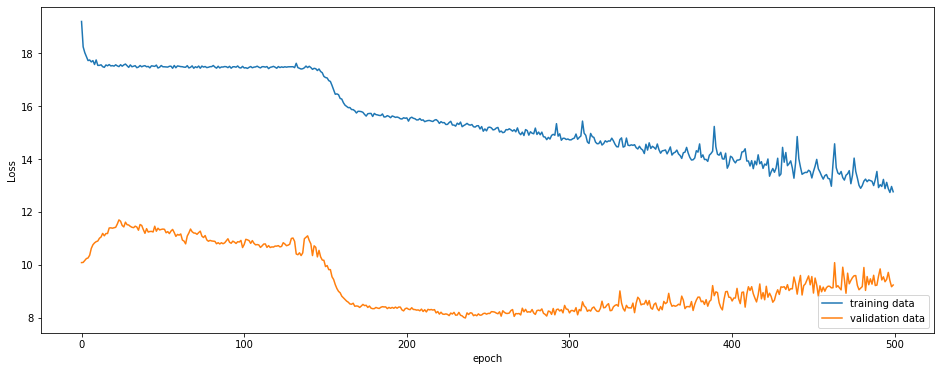

In [108]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model5.history['loss'])
plt.plot(learning_model5.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [99]:
model5 = tf.keras.models.load_model('LSTM_timestepTest_fiveTimestep.h5')

In [100]:
#performance on training set
trainPredict5 = model5.predict(trainX_5step_arr)
# calculate root mean squared error
trainScore5 = math.sqrt(mean_squared_error(trainY_5step_arr, trainPredict5))
trainR2Score5 = r2_score(trainY_5step_arr, trainPredict5)
trainSscore5 = findSscore(trainY_5step_arr, trainPredict5)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore5, trainR2Score5, trainSscore5))

Train Score: 3.9262 RMSE 0.1121 R2 Score 4656.7834 S score


In [101]:
#performance on validation set
valPredict5 = model5.predict(valX_5step_arr)
# calculate root mean squared error
valScore5 = math.sqrt(mean_squared_error(valY_5step_arr, valPredict5))
valR2Score5 = r2_score(valY_5step_arr, valPredict5)
valSscore5 = findSscore(valY_5step_arr, valPredict5)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore5, valR2Score5, valSscore5))

Validation Score: 2.8255 RMSE 0.2075 R2 Score 685.5376 S score


In [102]:
(actualVal5, predictedVal5) = getRULValues(valPredict5, allRUL, valTime_5step, 6010, 6976)

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


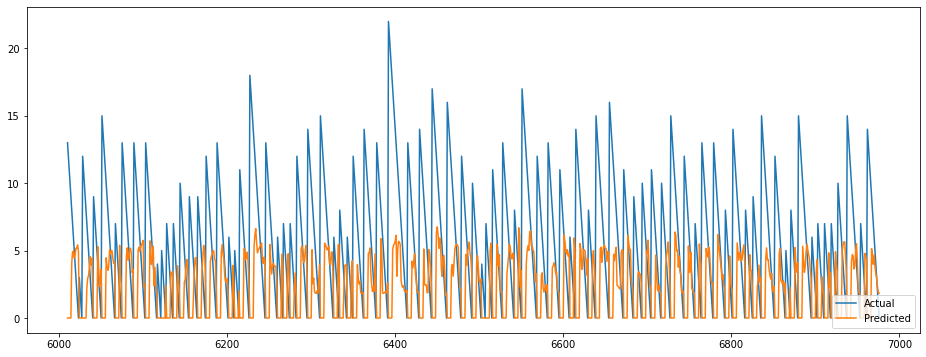

In [103]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal5)
plt.plot(timeLabels, predictedVal5)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

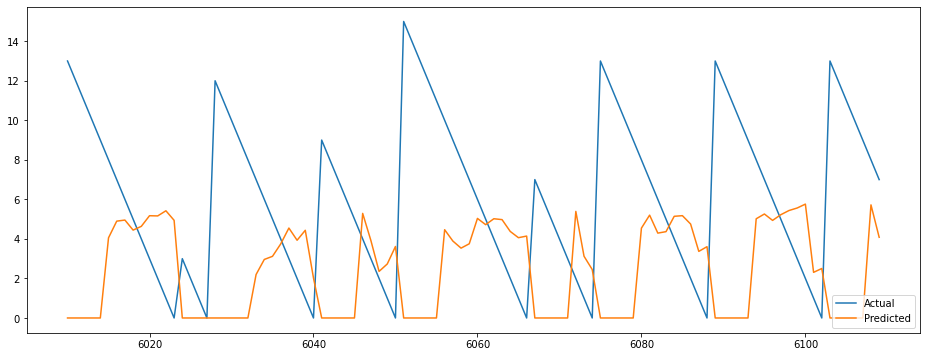

In [104]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal5[0:100])
plt.plot(timeLabels[0:100], predictedVal5[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()